# Software Development Capability Analysis
## by Marc Vitalis

## Preliminary Wrangling

> Briefly introduce your dataset here.

In [33]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from pandas.api.types import CategoricalDtype

%matplotlib inline

> Load in your dataset and describe its properties through the questions below.
Try and motivate your exploration goals through this section.

In [34]:
workitems = pd.read_csv('workitems_master.csv')
workitems.head()

,id,workitem_type,estimate,words,rel,sprint,assigned_to,new,doing,done,actual_work
0,797499,Story,80.0,"ancillary,optimization,price",NaN,NaN,navarrj,2014-10-11 04:38:57.880,2014-10-11 04:38:58.517,2014-10-11 04:39:11.530,0
1,797559,Bug,NaN,"allows,comparison,currencies,different,engine,...",NaN,NaN,navarrj,2014-10-11 04:42:56.663,2014-10-11 04:42:57.200,2014-10-11 04:42:58.273,0
2,797564,Bug,NaN,"pollingintervalseconds,tokenized",NaN,NaN,navarrj,2014-10-11 04:43:14.343,2014-10-11 04:43:14.937,2014-10-11 04:43:15.983,0
3,797575,Bug,NaN,"createdutc,import,included,json,optimization,tool",NaN,NaN,navarrj,2014-10-11 04:43:48.687,2014-10-11 04:43:52.327,2014-10-11 04:43:52.957,0
4,797576,Bug,NaN,"analytics,exporting,fields,importer,null",NaN,NaN,navarrj,2014-10-11 04:43:54.870,2014-10-11 04:43:57.573,2014-10-11 04:43:58.137,0


In [35]:
workitems.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1124 entries, 0 to 1123
Data columns (total 11 columns):
id               1124 non-null int64
workitem_type    1124 non-null object
estimate         220 non-null float64
words            1119 non-null object
rel              517 non-null object
sprint           1020 non-null float64
assigned_to      1124 non-null object
new              1124 non-null object
doing            1124 non-null object
done             1124 non-null object
actual_work      1124 non-null int64
dtypes: float64(2), int64(2), object(7)
memory usage: 96.7+ KB


**Convert Dates to Date type**

Date format are represented as string (object), we should change them first to datetime format.

In [36]:
workitems.new = pd.to_datetime(workitems.new)
workitems.doing = pd.to_datetime(workitems.doing)
workitems.done = pd.to_datetime(workitems.done)

workitems.head()

,id,workitem_type,estimate,words,rel,sprint,assigned_to,new,doing,done,actual_work
0,797499,Story,80.0,"ancillary,optimization,price",NaN,NaN,navarrj,2014-10-11 04:38:57.880,2014-10-11 04:38:58.517,2014-10-11 04:39:11.530,0
1,797559,Bug,NaN,"allows,comparison,currencies,different,engine,...",NaN,NaN,navarrj,2014-10-11 04:42:56.663,2014-10-11 04:42:57.200,2014-10-11 04:42:58.273,0
2,797564,Bug,NaN,"pollingintervalseconds,tokenized",NaN,NaN,navarrj,2014-10-11 04:43:14.343,2014-10-11 04:43:14.937,2014-10-11 04:43:15.983,0
3,797575,Bug,NaN,"createdutc,import,included,json,optimization,tool",NaN,NaN,navarrj,2014-10-11 04:43:48.687,2014-10-11 04:43:52.327,2014-10-11 04:43:52.957,0
4,797576,Bug,NaN,"analytics,exporting,fields,importer,null",NaN,NaN,navarrj,2014-10-11 04:43:54.870,2014-10-11 04:43:57.573,2014-10-11 04:43:58.137,0


In [37]:
workitems.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1124 entries, 0 to 1123
Data columns (total 11 columns):
id               1124 non-null int64
workitem_type    1124 non-null object
estimate         220 non-null float64
words            1119 non-null object
rel              517 non-null object
sprint           1020 non-null float64
assigned_to      1124 non-null object
new              1124 non-null datetime64[ns]
doing            1124 non-null datetime64[ns]
done             1124 non-null datetime64[ns]
actual_work      1124 non-null int64
dtypes: datetime64[ns](3), float64(2), int64(2), object(4)
memory usage: 96.7+ KB


**Convert Releases to Numeric**

In [38]:
workitems.loc[workitems.sprint.isna(), 'sprint'] = 0
workitems.sprint = workitems.sprint.astype(int)
workitems.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1124 entries, 0 to 1123
Data columns (total 11 columns):
id               1124 non-null int64
workitem_type    1124 non-null object
estimate         220 non-null float64
words            1119 non-null object
rel              517 non-null object
sprint           1124 non-null int32
assigned_to      1124 non-null object
new              1124 non-null datetime64[ns]
doing            1124 non-null datetime64[ns]
done             1124 non-null datetime64[ns]
actual_work      1124 non-null int64
dtypes: datetime64[ns](3), float64(1), int32(1), int64(2), object(4)
memory usage: 92.3+ KB


**Convert Category Types**

In [39]:
workitems.workitem_type.value_counts()

Bug      825
Story    235
Issue     64
Name: workitem_type, dtype: int64

In [40]:
workitem_types = CategoricalDtype(categories = ['Story', 'Bug', 'Issue'], ordered=False)
workitems.workitem_type = workitems.workitem_type.astype(workitem_types)
workitems.head()

,id,workitem_type,estimate,words,rel,sprint,assigned_to,new,doing,done,actual_work
0,797499,Story,80.0,"ancillary,optimization,price",NaN,0,navarrj,2014-10-11 04:38:57.880,2014-10-11 04:38:58.517,2014-10-11 04:39:11.530,0
1,797559,Bug,NaN,"allows,comparison,currencies,different,engine,...",NaN,0,navarrj,2014-10-11 04:42:56.663,2014-10-11 04:42:57.200,2014-10-11 04:42:58.273,0
2,797564,Bug,NaN,"pollingintervalseconds,tokenized",NaN,0,navarrj,2014-10-11 04:43:14.343,2014-10-11 04:43:14.937,2014-10-11 04:43:15.983,0
3,797575,Bug,NaN,"createdutc,import,included,json,optimization,tool",NaN,0,navarrj,2014-10-11 04:43:48.687,2014-10-11 04:43:52.327,2014-10-11 04:43:52.957,0
4,797576,Bug,NaN,"analytics,exporting,fields,importer,null",NaN,0,navarrj,2014-10-11 04:43:54.870,2014-10-11 04:43:57.573,2014-10-11 04:43:58.137,0


In [41]:
workitems.describe()

,id,estimate,sprint,actual_work
count,1.124000e+03,220.000000,1124.000000,1124.000000
mean,1.624189e+06,22.235455,18.917260,6.525801
std,3.635441e+05,25.440946,14.283334,11.785039
min,7.974990e+05,0.500000,0.000000,-34.000000
25%,1.420588e+06,5.000000,3.000000,0.000000
50%,1.630103e+06,13.000000,21.000000,1.000000
75%,1.860012e+06,30.000000,31.000000,9.000000
max,2.341603e+06,144.000000,48.000000,94.000000


### What is the structure of your dataset?

> The dataset consists of 2393, with 10 features (workitem_type, estimate, words, rel (release), sprint, assigned_to, new (date started), doing (date started working), done, and actual work (done - doing). Variables main point of interest are the date stamps for the work. Some are just to describe the work item such as sprint, release and assigned_to.

### What is/are the main feature(s) of interest in your dataset?

> I'm more interested how variables affects `actual_work`. The goal is find out for the patterns that affects the actual work.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> The dataset contains data and underwent to three (3) SDLC pattern (non-structured, semi-agile, scrum). The date stamps are very important (`new`, `doing`, `done`), this will help me extract important information, such as days of the week, months, or observe the time flow pattern if the SDLC pattern improves through time, or made it worst. As bonus I can also make use the correlation of titles to the actual work.

## Univariate Exploration

> First to explore is the main point of interest, `actual_work`.

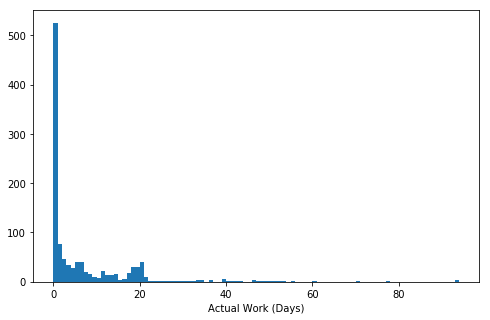

In [42]:
binsize = 1
bins = np.arange(0, workitems.actual_work.max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = workitems, x = 'actual_work', bins = bins)
plt.xlabel('Actual Work (Days)')
plt.show()

There's a huge spike on the 0-1 area, it's unlikely to have a workitem with zero day done, that is considered as no effort. Let's tidy this a bit.

In [43]:
#zero sum should be converted to a day of work if they have worked on it at least 2h
zero_work = workitems.actual_work == 0
workitems.loc[zero_work, 'actual_work'] = 1

#just remove the zero effort ones
workitems = workitems[((workitems.done - workitems.doing) / pd.Timedelta(hours = 1)) >  2]
workitems.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 799 entries, 24 to 1123
Data columns (total 11 columns):
id               799 non-null int64
workitem_type    799 non-null category
estimate         203 non-null float64
words            795 non-null object
rel              452 non-null object
sprint           799 non-null int32
assigned_to      799 non-null object
new              799 non-null datetime64[ns]
doing            799 non-null datetime64[ns]
done             799 non-null datetime64[ns]
actual_work      799 non-null int64
dtypes: category(1), datetime64[ns](3), float64(1), int32(1), int64(2), object(3)
memory usage: 66.4+ KB


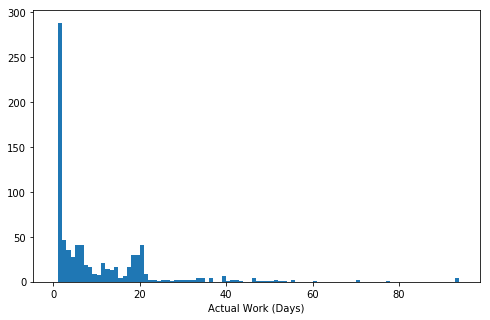

In [44]:
plt.figure(figsize=[8, 5])
plt.hist(data = workitems, x = 'actual_work', bins = bins)
plt.xlabel('Actual Work (Days)')
plt.show()

Still a huge spike in 1, and have a very long tail, let's redistribute it with log scale.

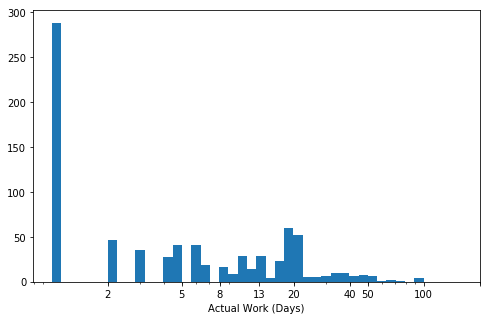

In [45]:
# try log scale since it has a long tail
log_binsize = 0.05
bins = 10 ** np.arange(0, np.log10(workitems['actual_work'].max())+log_binsize, log_binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = workitems, x = 'actual_work', bins = bins)
plt.xscale('log')
plt.xticks([2, 5, 8, 13, 20, 40, 50, 100, 200], [2, 5, 8, 13, 20, 40, 50, 100])
plt.xlabel('Actual Work (Days)')
plt.show()

We still have a big spike at one day work, and another clump in `20` days, somehow even distribution from `2-20`. On the later sprints, the team is now doing a 3 week scrum, which is somehow the same to 20 days.

It seems unusual to have work items that's take more than 30 days. Also, there's a big value on workitems th Let's try to find out if they are outliers.

The first thing to look at are the ones with value `1`.

In [46]:
#get items with actual_work = 1, and investigate the data
ones = workitems[workitems.actual_work == 1]
ones

,id,workitem_type,estimate,words,rel,sprint,assigned_to,new,doing,done,actual_work
26,817499,Bug,NaN,"refactor,suggestions",NaN,0,navarrj,2014-11-17 02:16:46.527,2014-11-17 02:16:54.347,2014-11-17 09:45:24.323,1
36,847759,Bug,NaN,"build,errors,files,fix,folder,missing,mmtempla...",NaN,1,navarrj,2015-01-13 09:06:35.230,2015-01-13 09:07:07.200,2015-01-14 10:45:05.377,1
44,891430,Bug,NaN,"calculatedfrom,computation,correct",NaN,6,navarrj,2015-03-23 01:59:01.580,2015-03-23 02:39:46.533,2015-03-23 11:29:29.363,1
47,892179,Bug,NaN,"analytics,missing,records,ruletype",NaN,6,beckrob,2015-03-23 23:12:29.850,2015-03-25 11:56:43.810,2015-03-25 15:36:00.070,1
48,892184,Bug,NaN,"experiment,have,make,old,optimization,optimiza...",NaN,6,beckrob,2015-03-23 23:17:04.243,2015-03-24 15:55:17.863,2015-03-25 15:31:00.020,1
52,896967,Bug,NaN,"closed,dialog,host,killed,manager,opened,proce...",NaN,6,navarrj,2015-03-30 08:17:12.370,2015-04-06 10:09:05.907,2015-04-07 07:41:24.283,1
56,899080,Bug,2.0,"cannot,cleared,derivedinputparameter,records",NaN,7,navarrj,2015-04-01 10:16:49.403,2015-04-06 17:44:32.690,2015-04-07 10:59:07.667,1
58,899456,Bug,NaN,"analytics,causes,collisions,endpoint,host,name...",NaN,7,whitakn,2015-04-01 19:14:48.580,2015-04-15 21:15:36.587,2015-04-16 10:33:29.817,1
59,900506,Bug,1.0,"categorical,decisiontree,error,import,splitpoi...",NaN,7,navarrj,2015-04-06 05:50:05.407,2015-04-06 22:53:36.690,2015-04-07 09:11:04.030,1
60,900528,Bug,4.0,"decisiontree,encountered,error,getting,optimiz...",NaN,7,vitalim,2015-04-06 06:34:40.363,2015-04-06 22:41:54.280,2015-04-07 10:52:29.427,1


In [47]:
ones.workitem_type.value_counts()

Bug      257
Issue     19
Story     12
Name: workitem_type, dtype: int64

By visual investigation, most of the workitems with `actual_work == 1` are mostly bugs. Now this make sense as bugs usually are quick to fix. Let's get their actual values.

Next, let's investigate those workitems with more than 30 days value.

In [48]:
workitems[workitems.actual_work > 30]

,id,workitem_type,estimate,words,rel,sprint,assigned_to,new,doing,done,actual_work
33,831062,Story,66.0,"analytics,decision,engine,processing,rules,tree",NaN,1,olsonju,2014-12-09 22:09:09.940,2014-12-15 16:49:59.340,2015-01-21 15:14:34.063,36
41,870426,Story,84.0,cleanup,NaN,13,vitalim,2015-02-18 20:21:17.197,2015-06-01 21:00:49.570,2015-07-14 01:13:22.640,42
122,1214157,Story,32.0,"ability,list,pricing,receive,request,support",NaN,17,vitalim,2016-01-12 19:58:13.793,2016-08-19 08:01:42.340,2016-09-22 09:44:54.930,34
136,1253185,Story,9.0,"apo,cache,creating,gui,make,management,operati...",NaN,17,navarrj,2016-02-24 07:33:26.437,2016-08-19 08:07:58.117,2016-10-05 03:09:08.163,46
151,1272098,Bug,NaN,"active,after,already,appears,editing,inactive,...",NaN,20,limmari,2016-03-18 03:26:58.817,2016-09-05 07:04:39.967,2016-10-07 10:12:03.640,32
204,1329858,Story,30.0,"cached,data,offer,view",NaN,17,navarrj,2016-06-02 23:27:11.827,2016-08-19 08:04:41.320,2016-10-10 09:39:06.883,52
217,1337113,Story,76.0,"decision,deploy,effort,reduce,rules,tree",NaN,17,delossj,2016-06-11 17:32:07.517,2016-08-19 08:03:23.350,2016-10-11 10:36:09.250,53
225,1344433,Story,32.0,"clear,cli,code,enhance,specific",NaN,17,panuelk,2016-06-22 05:56:42.467,2016-08-19 08:11:23.240,2016-10-05 03:02:29.863,46
226,1346516,Story,46.0,"accept,apo,conditionally,priced,products,zero",NaN,17,navarrj,2016-06-26 03:13:13.260,2016-08-19 08:19:18.763,2016-09-22 09:44:44.747,34
227,1346646,Story,30.0,"cli,create,original,price,pricing,relative,scr...",NaN,17,vitalim,2016-06-27 01:50:38.137,2016-08-02 03:34:13.053,2016-09-22 09:44:26.237,51


Items here are either from our work when we are still doing `waterfall`, or the newer ones, they are legitimate workitems that got back and forth in development, and some went to hiatus, and still they are valid data.

Let's find out the averages.

In [49]:
[workitems.actual_work.mean(), workitems.actual_work.median(), workitems.actual_work.mode()]

[9.525657071339173, 5.0, 0    1
 dtype: int64]

We have different data here. Mean, says a workitem can be done 9 days, average. This is hardly conclusive as we have work items that's pulling the value up. Median however, makes a bit more sense as a normal workitem is normally done 5 days. 1 has more occurrence, but since this data is not categorical, it just provides a bit of information about the data.

Based from the information gathered from the team, one day of work are mostly possible for what they call `Bug Fest`. More exploring on the relationship of the `actual_work` and `workitem_type`. For now, let's investigate the distribution of the `workitem_type`.

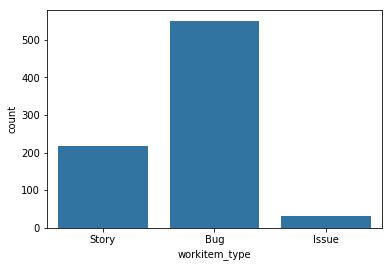

In [50]:
base_color = sb.color_palette()[0]
sb.countplot(data = workitems, x = 'workitem_type', color = base_color)

That's a big number of bugs in comparison to stories. Which makes sense for the spike in 1 day `actual_work` in the data. Let's explore the data further by looking into number of workitems being worked on per month.

In [51]:
# let's extract the dates first
workitems['doing_year'] = workitems.doing.dt.year
workitems['done_year'] = workitems.done.dt.year
workitems['new_year'] = workitems.new.dt.year

workitems['doing_month'] = workitems.doing.dt.strftime('%b')
workitems['done_month'] = workitems.done.dt.strftime('%b')
workitems['new_month'] = workitems.new.dt.strftime('%b')

workitems['doing_dow'] = workitems.doing.dt.strftime('%a')
workitems['done_dow'] = workitems.done.dt.strftime('%a')
workitems['new_dow'] = workitems.new.dt.strftime('%a')

workitems['doing_my'] = workitems.doing.dt.strftime('%b %Y')
workitems['done_my'] = workitems.done.dt.strftime('%b %Y')
workitems['new_my'] = workitems.new.dt.strftime('%b %Y')

weekdays_type = CategoricalDtype(categories=['Mon' , 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], ordered=True)
months_type = CategoricalDtype(categories=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], ordered=True)

workitems.doing_month = workitems.doing_month.astype(months_type)
workitems.done_month = workitems.done_month.astype(months_type)
workitems.new_month = workitems.new_month.astype(months_type)

workitems.doing_dow = workitems.doing_dow.astype(weekdays_type)
workitems.done_dow = workitems.done_dow.astype(weekdays_type)
workitems.new_dow = workitems.new_dow.astype(weekdays_type)

workitems.head()

,id,workitem_type,estimate,words,rel,sprint,assigned_to,new,doing,done,...,new_year,doing_month,done_month,new_month,doing_dow,done_dow,new_dow,doing_my,done_my,new_my
24,799056,Story,66.0,"analytic,logging,treatment",NaN,0,vitalim,2014-10-13 22:56:09.130,2014-11-17 06:34:24.533,2014-11-26 06:39:50.240,...,2014,Nov,Nov,Oct,Mon,Wed,Mon,Nov 2014,Nov 2014,Oct 2014
26,817499,Bug,NaN,"refactor,suggestions",NaN,0,navarrj,2014-11-17 02:16:46.527,2014-11-17 02:16:54.347,2014-11-17 09:45:24.323,...,2014,Nov,Nov,Nov,Mon,Mon,Mon,Nov 2014,Nov 2014,Nov 2014
27,819151,Bug,NaN,"default,logging,treatment,values",NaN,0,navarrj,2014-11-19 07:41:35.487,2014-11-19 07:41:41.997,2014-11-24 07:44:26.163,...,2014,Nov,Nov,Nov,Wed,Mon,Wed,Nov 2014,Nov 2014,Nov 2014
28,820565,Bug,NaN,"cache,check,logger,setting,treatment",NaN,0,vitalim,2014-11-21 07:48:09.477,2014-11-21 07:48:19.043,2014-11-24 06:35:03.113,...,2014,Nov,Nov,Nov,Fri,Mon,Fri,Nov 2014,Nov 2014,Nov 2014
31,826643,Story,47.0,"analytics,automation,factory",NaN,6,vitalim,2014-12-01 20:51:01.833,2015-03-20 21:04:55.173,2015-04-01 07:57:07.490,...,2014,Mar,Apr,Dec,Fri,Wed,Mon,Mar 2015,Apr 2015,Dec 2014


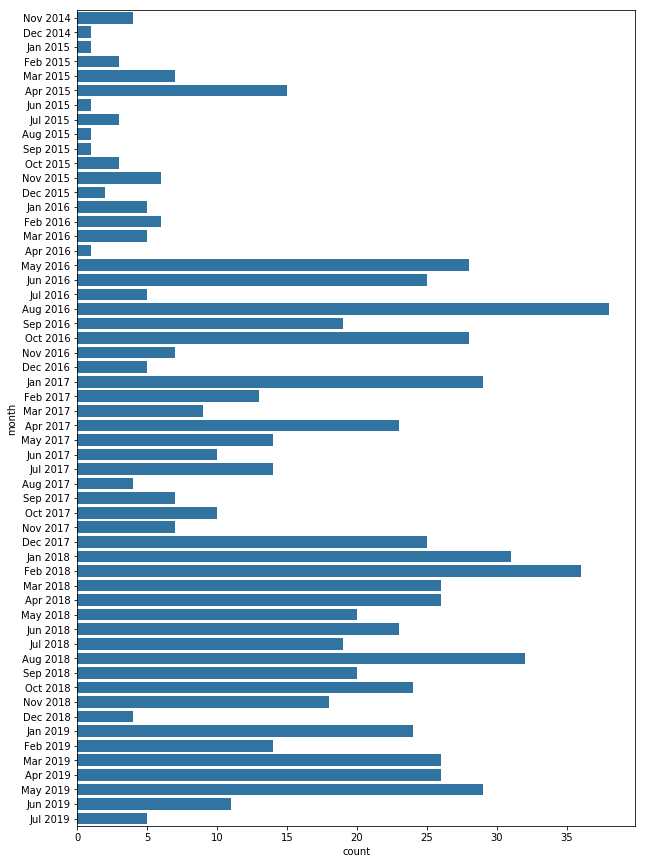

In [52]:
work_month = workitems.sort_values(['doing'])
work_month['month'] = work_month.doing.dt.strftime('%b %Y')

plt.figure(figsize=(10, 15))
sb.countplot(data = work_month, y = 'month', color = base_color)

As the date has become more recent, it's getting more consistent on the number of workitems. We don't know yet the distribution of how many of these are stories, bugs or issues. More on that later.

With scrums, there's a normal trend that during Fridays, there's a spike of things suddenly getting done. Let's investigate the distribution on weekdays, both on `doing` and `done`.

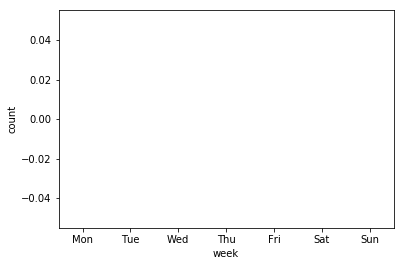

In [53]:


work_wk_doing = workitems

work_wk_doing['week'] = workitems.doing.dt.strftime('%A').astype(weekdays_type)

sb.countplot(data = work_wk_doing, x = 'week', color = base_color)

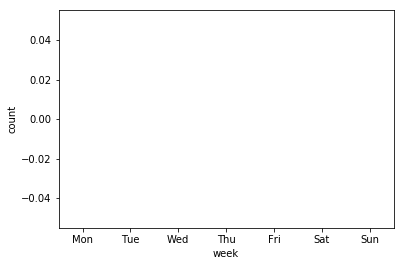

In [54]:
work_wk_done = workitems

work_wk_done['week'] = workitems.done.dt.strftime('%A').astype(weekdays_type)

sb.countplot(data = work_wk_done, x = 'week', color = base_color)

This shows that the team is more productive when fresh during `Mondays`, finishing most items on `Tuesdays` and tends to slow down throughout the week.

The next we'll look at is the distribution for product when creating new features.

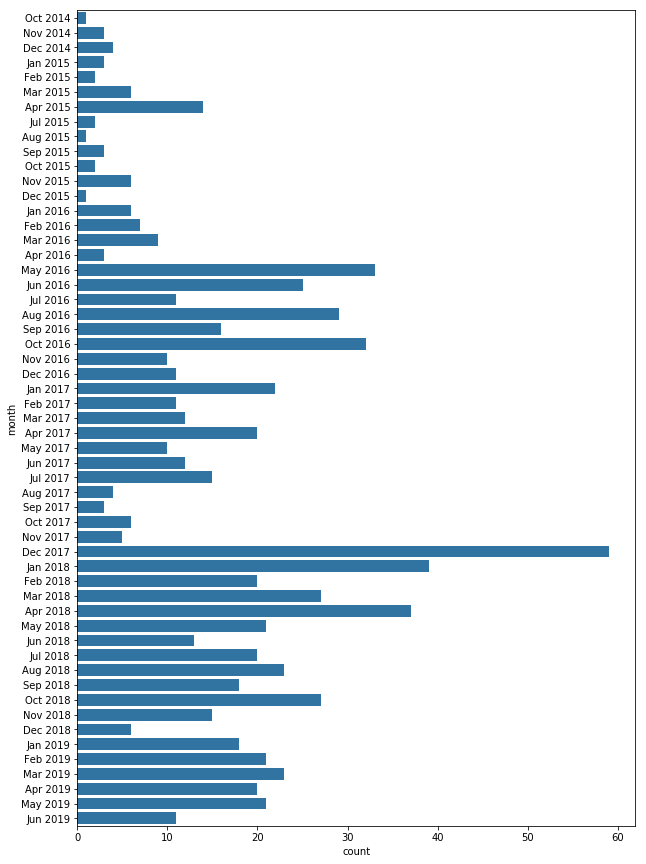

In [55]:
idea_month = workitems.sort_values(['new'])
idea_month['month'] = idea_month.new.dt.strftime('%b %Y')

plt.figure(figsize=(10, 15))
sb.countplot(data = idea_month, y = 'month', color = base_color)

There are 3 occurences when stories are created in bulk, `April 2015`, `May - Oct 2016` and `Dec 2017`. These are interesting points to ask what happened during these events. Let's check which day of the week normally the Product Team mostly creates stories.

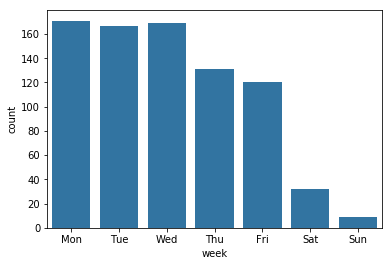

In [56]:
work_wk_idea = workitems

work_wk_idea['week'] = workitems.new.dt.strftime('%a').astype(weekdays_type)

sb.countplot(data = work_wk_idea, x = 'week', color = base_color)

There's a balance on when they add stories in the whole week, of course `Saturdays` and `Sundays` are holidays.

Let's observe the workitems per sprint.

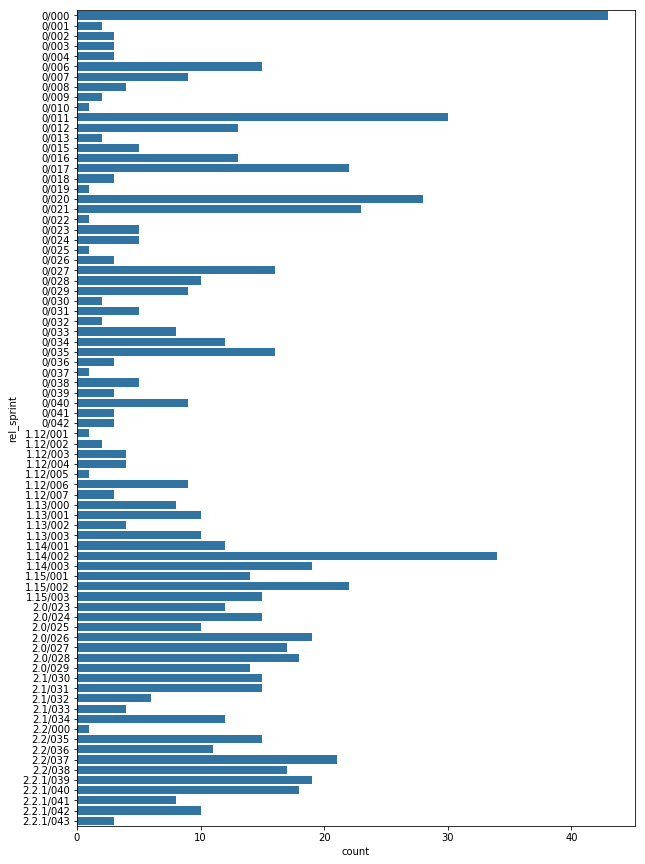

In [57]:
#TODO remove nan in sprint and change to int
work_sprint = workitems
work_sprint.loc[work_sprint.rel.isna(), 'rel'] = '0'
work_sprint = work_sprint.sort_values(['rel', 'sprint'])

work_sprint['rel_sprint'] = work_sprint.rel + '/' + work_sprint.sprint.astype(str).str.pad(width = 3, side = 'left', fillchar = '0')

plt.figure(figsize=(10, 15))
sb.countplot(data = work_sprint, y = 'rel_sprint', color = base_color)

The work items in each releases vary. Although there are items that slotted in Sprint zero which means there might be error in input on those.

Next to investigate is the estimates provided.

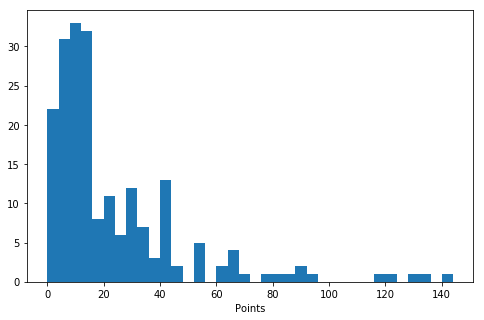

In [58]:
binsize = 4
bins = np.arange(0, workitems.estimate.max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = workitems, x = 'estimate', bins = bins)
plt.xlabel('Points')
plt.show()

Again, it has a long tail. Let's try plotting the log.

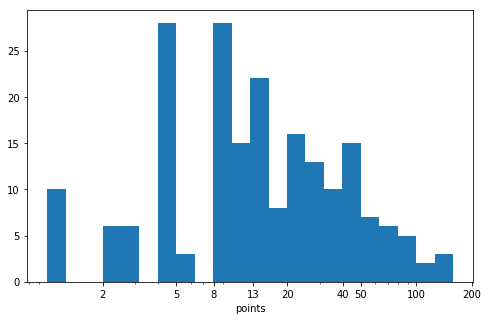

In [59]:
# try log scale since it has a long tail
log_binsize = 0.1
bins = 10 ** np.arange(0, np.log10(workitems['estimate'].max())+log_binsize, log_binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = workitems, x = 'estimate', bins = bins)
plt.xscale('log')
plt.xticks([2, 5, 8, 13, 20, 40, 50, 100, 200], [2, 5, 8, 13, 20, 40, 50, 100, 200])
plt.xlabel('points')
plt.show()

Distribution has its peak between 8 to 13 estimates. Based on my conversation with the team, this is the 'just enough' size of stories.

Last to explore are the title broken down into words. Let's find out the top 40 word occurence.

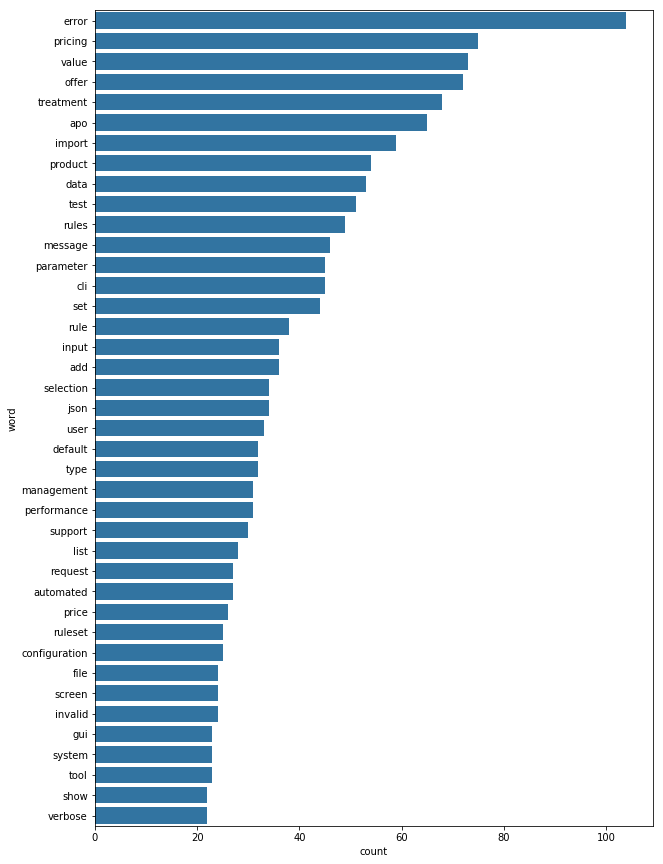

In [60]:
work_words = workitems[['id', 'words']]

work_words = work_words[['id', 'words']].words.str.split(',').apply(pd.Series) \
    .merge(work_words[['id', 'words']], right_index = True, left_index = True) \
    .drop(["words"], axis = 1) \
    .melt(id_vars = ['id'], value_name = "word") \
    .drop("variable", axis = 1) \
    .dropna()

plt.figure(figsize=(10, 15))
sb.countplot(data = work_words, y = 'word', color = base_color, order = work_words.word.value_counts().iloc[:40].index)

Results is interesting. Top entry is error, which probably evident mostly on bug items. Other items in top 40 mostly can describe the application itself.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

The actual work contains `zero` days which means `no effort`. I recalculated the actual effort by getting what's normally considered as work which is `2 hours`, and considered that already as one day of work. There are also what seems to be outliers, with high value in `one-day work`, however, with investigation, I found out that these are mostly bugs which makes sense as bugs are usually easy to get done. On the high spectrum, I checked them online the patterns on why they have large values. Some of them are from our waterfall method which consists of large `stories` and took days to months just to finished. Some of the data are also difficult to resolve which spanned to multiple sprints. I feel that they are important part of our data for now.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

I recalculated `actual_work` to weed out the `no effort` stories. The words field are comma-delimited string, was converted into it's own data frame so we can examine them individually. To investigate individual characteristics of the dates, i also extracted `year`, `month` and `dow` of `new`, `doing` and `done`.

## Bivariate Exploration

First let's check pairwise correlation between features.

In [61]:
workitems.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 799 entries, 24 to 1123
Data columns (total 24 columns):
id               799 non-null int64
workitem_type    799 non-null category
estimate         203 non-null float64
words            795 non-null object
rel              799 non-null object
sprint           799 non-null int32
assigned_to      799 non-null object
new              799 non-null datetime64[ns]
doing            799 non-null datetime64[ns]
done             799 non-null datetime64[ns]
actual_work      799 non-null int64
doing_year       799 non-null int64
done_year        799 non-null int64
new_year         799 non-null int64
doing_month      799 non-null category
done_month       799 non-null category
new_month        799 non-null category
doing_dow        799 non-null category
done_dow         799 non-null category
new_dow          799 non-null category
doing_my         799 non-null object
done_my          799 non-null object
new_my           799 non-null object
week     

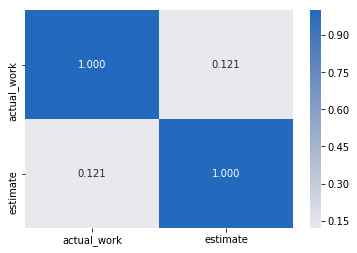

In [62]:
numeric_vars = ['actual_work', 'estimate']
categoric_vars = ['workitem_type', 'new_month', 'doing_month', 'done_month', 'new_dow', 'doing_dow', 'done_dow']

work_est = workitems[~workitems.estimate.isna()]

sb.heatmap(work_est[numeric_vars].corr(), annot = True, fmt = '.3f', cmap = 'vlag_r', center = 0)

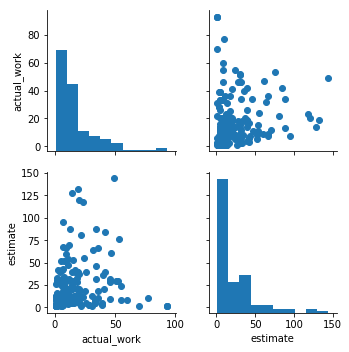

In [63]:
g = sb.PairGrid(data = work_est, vars = numeric_vars)
g = g.map_diag(plt.hist, bins = 10)
g.map_offdiag(plt.scatter)

Looking at this information, the correlation is close to zero, which means that estimating has no any relation to actual work, which makes the activity useless.

<Figure size 720x720 with 0 Axes>

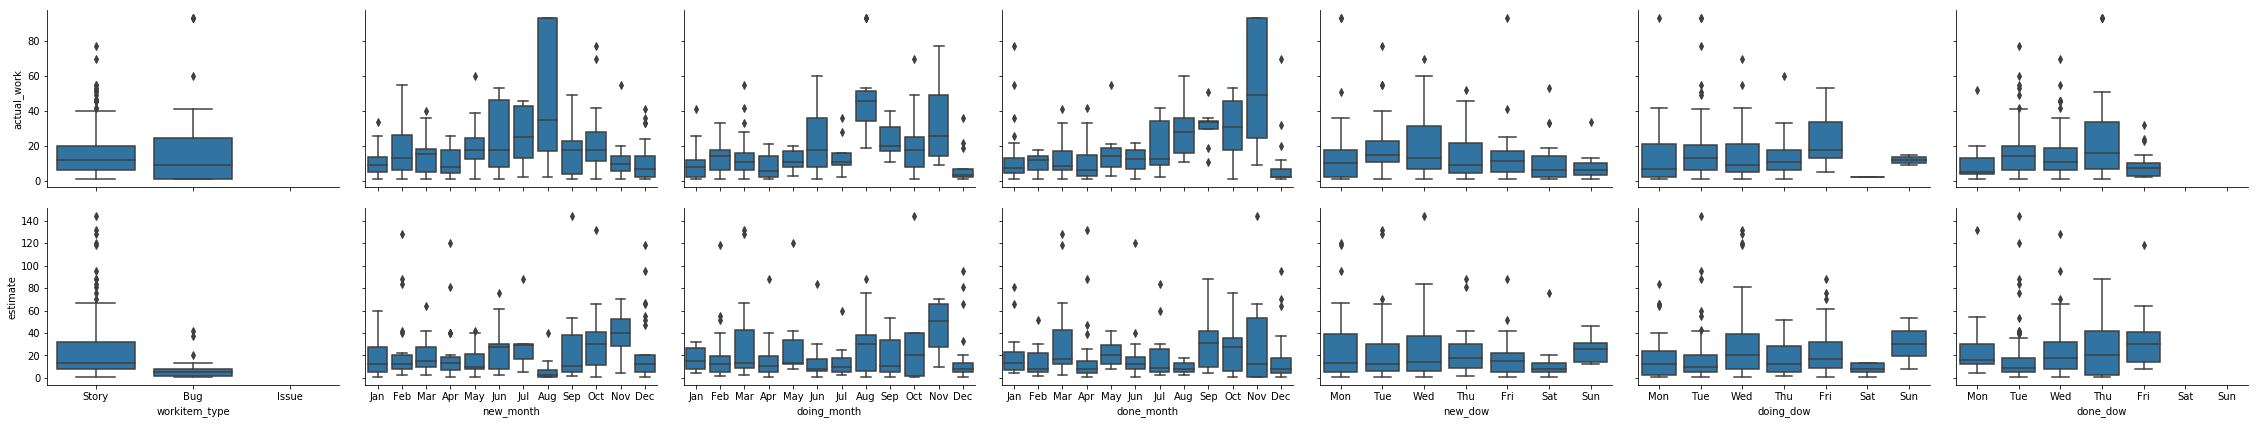

In [64]:
def boxgrid(x, y, **kwargs):
    """ Quick hack for creating box plots with seaborn's PairGrid. """
    default_color = sb.color_palette()[0]
    sb.boxplot(x, y, color = default_color)

plt.figure(figsize = [10, 10])
g = sb.PairGrid(data = work_est, y_vars = ['actual_work', 'estimate'], x_vars = categoric_vars,
                height = 3, aspect = 1.5)
g.map(boxgrid)
plt.show();

Another proof how far the the patterns for `actual_work` and `estimate`. A few things that can be observed here, there's little work done on `December` which is consistent as during this month, many of the resource take time off.

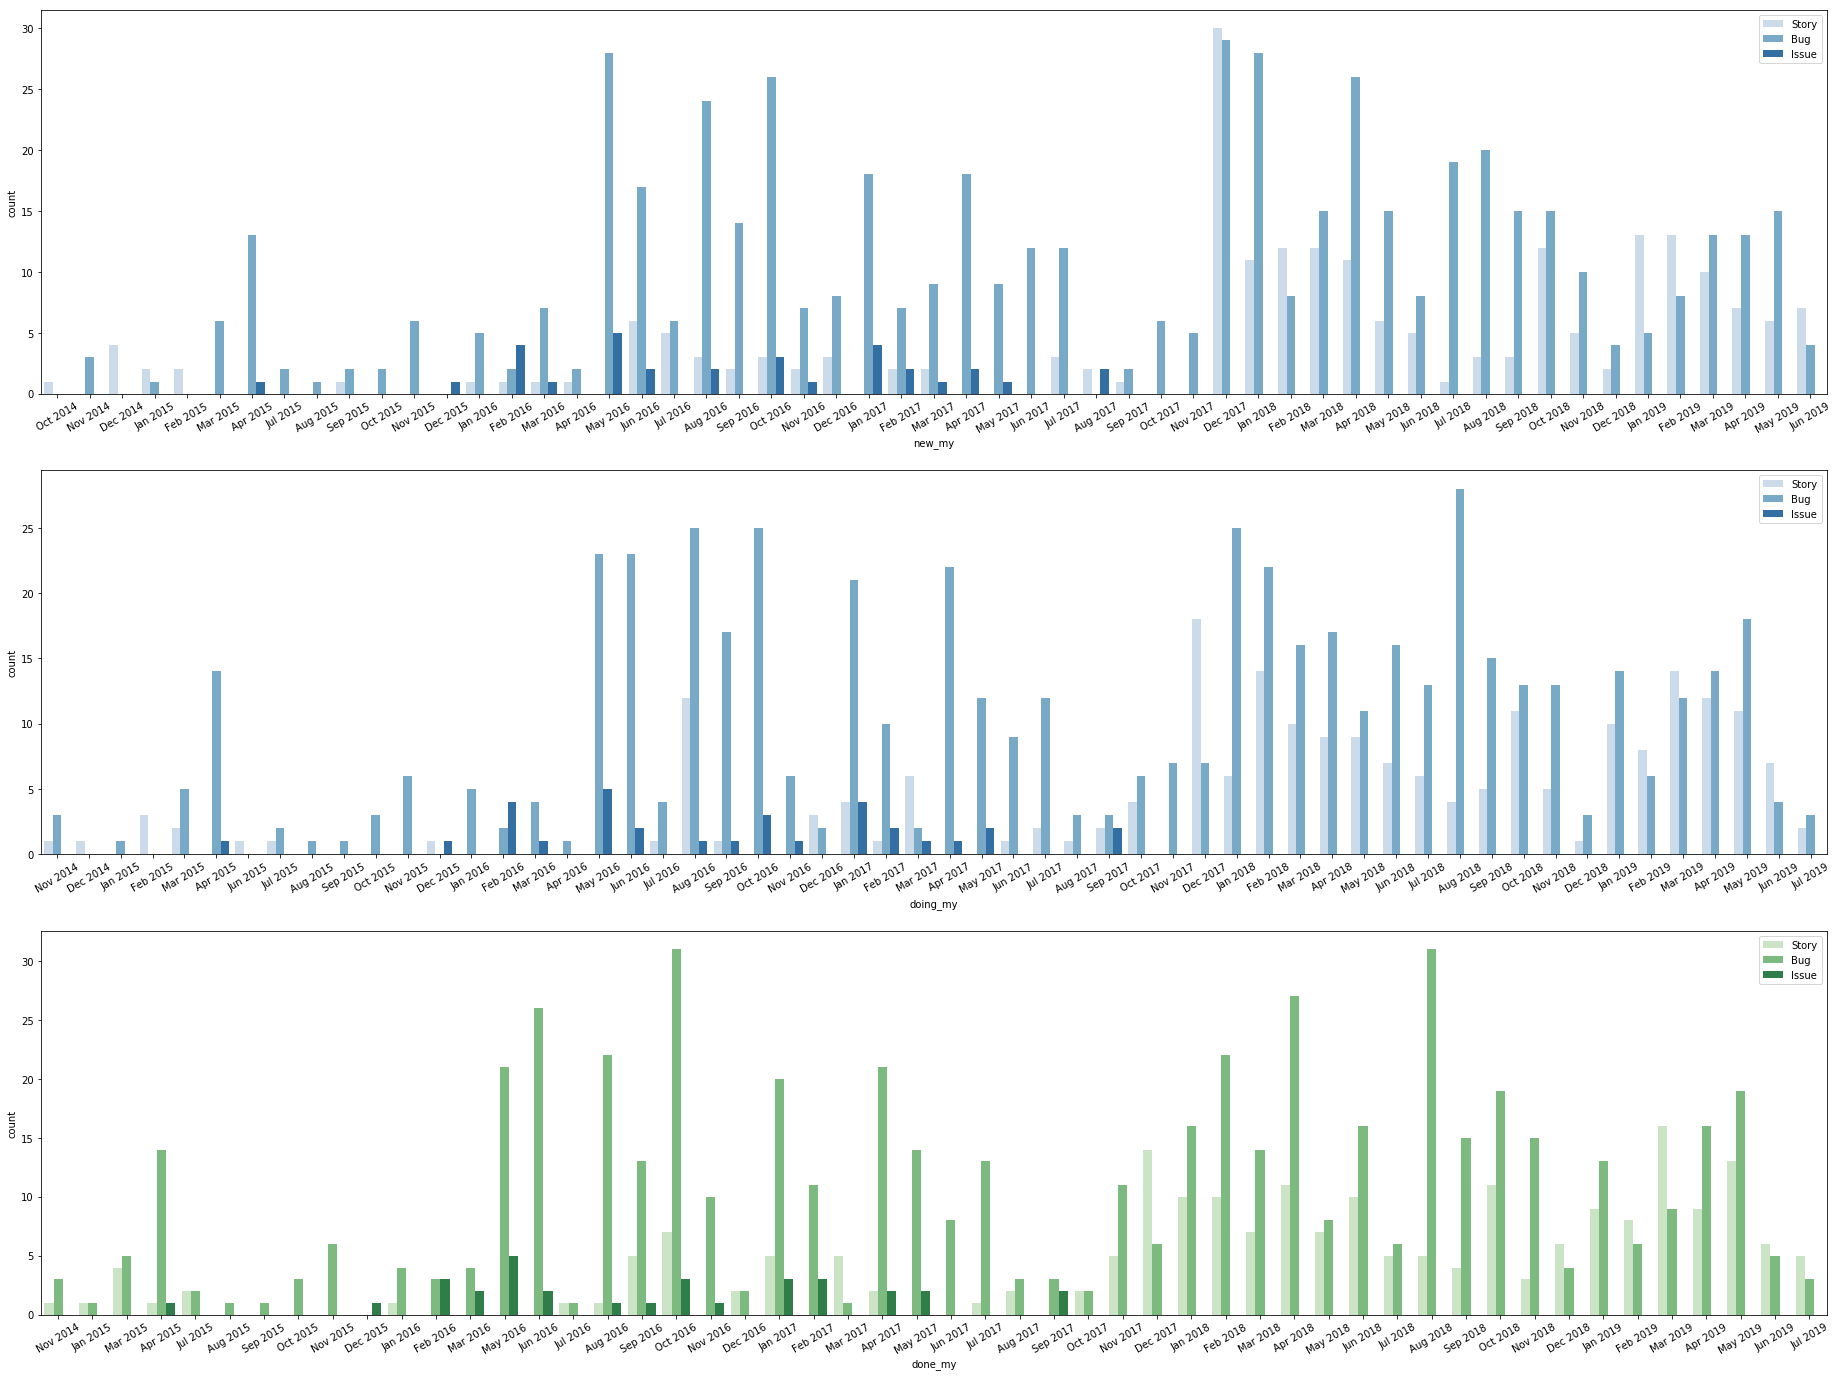

In [75]:
plt.figure(figsize = [32, 24])


ax = plt.subplot(3, 1, 1)
df = workitems.sort_values(['new_year', 'new_month'])
g = sb.countplot(data = df, x = 'new_my', hue = 'workitem_type', palette = 'Blues')
ax.legend(loc = 1, ncol = 1)
g.set_xticklabels(df.new_my.unique(), rotation=30)

ax = plt.subplot(3, 1, 2)
df = workitems.sort_values(['doing_year', 'doing_month'])
g = sb.countplot(data = df, x = 'doing_my', hue = 'workitem_type', palette = 'Blues')
ax.legend(loc = 1, ncol = 1) # re-arrange legend to reduce overlapping
g.set_xticklabels(df.doing_my.unique(), rotation=30)

ax = plt.subplot(3, 1, 3)
df = workitems.sort_values(['done_year', 'done_month'])
g = sb.countplot(data = df, x = 'done_my', hue = 'workitem_type', palette = 'Greens')
ax.legend(ncol = 1) # re-arrange legend to remove overlapping
g.set_xticklabels(df.done_my.unique(), rotation=30)

plt.show()

It's a common sight that most of the time, the team mostly working on bugs.

Let's take a closer look on story work items in relationship to months.

[Text(0, 0, '0'),
 Text(0, 0, '1'),
 Text(0, 0, '3'),
 Text(0, 0, '5'),
 Text(0, 0, '8'),
 Text(0, 0, '13'),
 Text(0, 0, '20')]

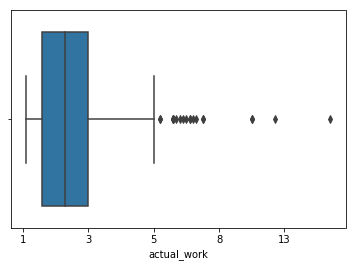

In [84]:
work_story = workitems[workitems.workitem_type == 'Story'].sort_values(['done_year', 'done_month'])
g = sb.boxplot(x=work_story.actual_work)
g.set_xticklabels([0, 1, 3, 5, 8, 13, 20, 40, 100])

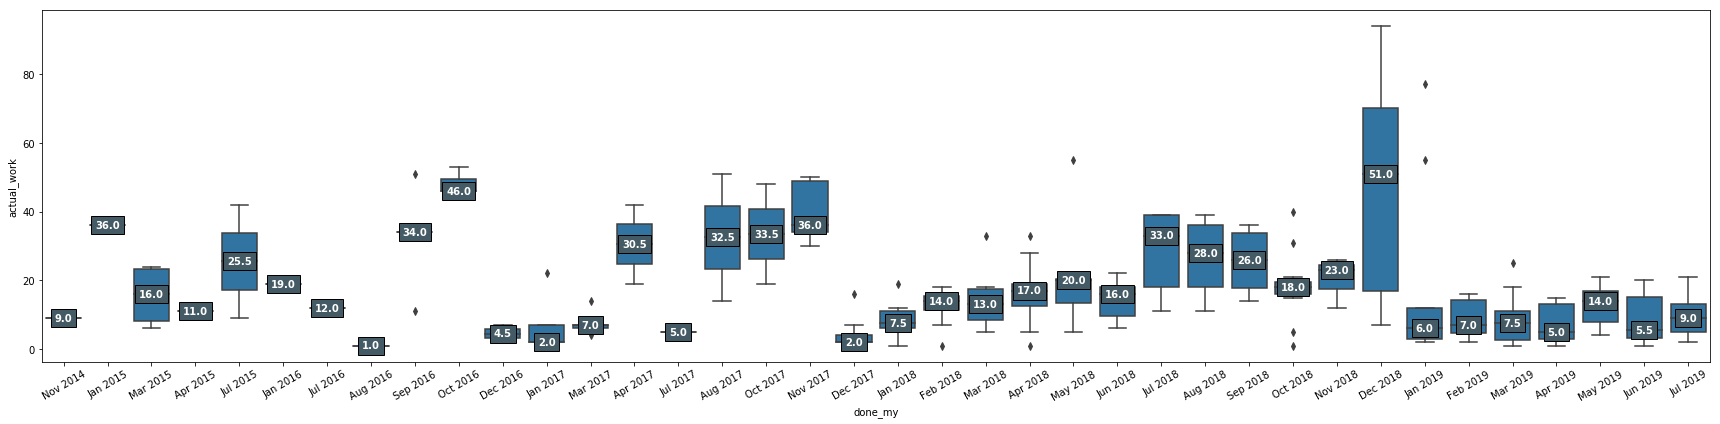

In [83]:
plt.figure(figsize=(24,6))
g = sb.boxplot(x="done_my", y="actual_work", data=work_story, color = base_color)
g.set_xticklabels(work_story.done_my.unique(), rotation=30);

ax = g.axes
lines = ax.get_lines()
categories = ax.get_xticks()

for cat in categories:
    # every 4th line at the interval of 6 is median  line
    y = round(lines[4+cat*6].get_ydata()[0],1) 

    ax.text(
        cat, 
        y, 
        f'{y}', 
        ha='center', 
        va='center', 
        fontweight='bold', 
        size=10,
        color='white',
        bbox=dict(facecolor='#445A64'))

g.figure.tight_layout()

The graph is pretty much random with regards to median. Let's observe this in some other visualization.

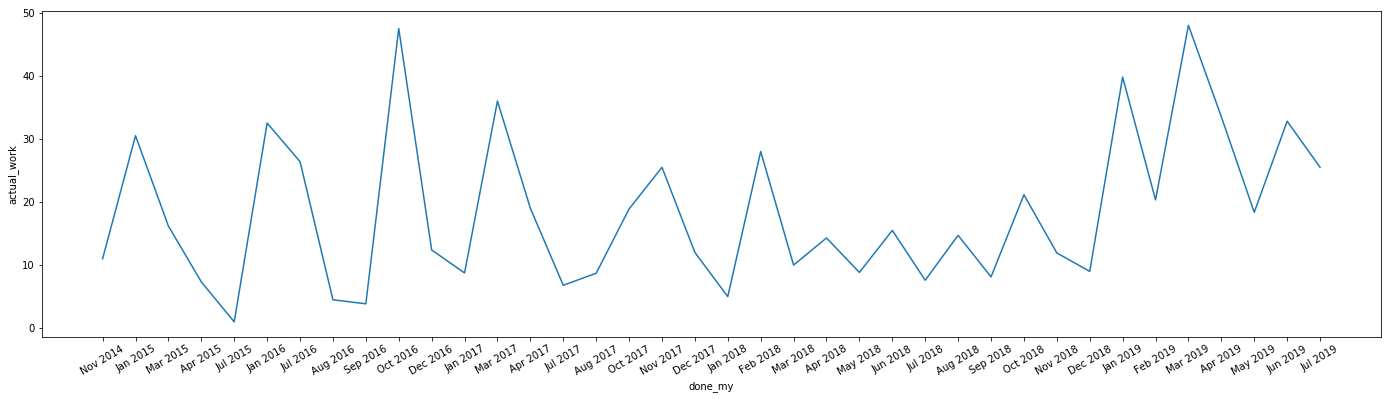

In [96]:
plt.figure(figsize=(24, 6))
g = sb.lineplot(data = work_story, x = 'done_my', y = 'actual_work', ci = None)
g.set_xticklabels(work_story.done_my.unique(), rotation=30);

In [92]:
work_story.groupby(['done_year', 'done_month']).actual_work.mean()

done_year  done_month
2014       Nov            9.000000
2015       Jan           36.000000
           Mar           15.500000
           Apr           11.000000
           Jul           25.500000
2016       Jan           19.000000
           Jul           12.000000
           Aug            1.000000
           Sep           32.800000
           Oct           48.000000
           Dec            4.500000
2017       Jan            6.800000
           Mar            7.600000
           Apr           30.500000
           Jul            5.000000
           Aug           32.500000
           Oct           33.500000
           Nov           39.800000
           Dec            3.857143
2018       Jan            8.700000
           Feb           12.400000
           Mar           14.714286
           Apr           16.181818
           May           21.142857
           Jun           14.300000
           Jul           28.000000
           Aug           26.400000
           Sep           25.50000

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> Your answer here!

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> Your answer here!

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Your answer here!

### Were there any interesting or surprising interactions between features?

> Your answer here!

> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!